<h1>Project Summary</h1>

<h3>Background</h3>

Taking a System on a Chip (SoC) from design through to the stage of timing converged is a multistep, iterative process that is time consuming and labor intensive. The process typically takes between 12-16 weeks as failures in the last step of the process can require fixes in the first stage - RTL thus restarting the process.

1. Each block owner must complete the layout and design according to the spec timing files given by the full chip team
2. The full chip team runs a timing analysis tool Prime Time to see if paths across mutliple blocks hit timing
3. Prime Time reports the paths that don't hit timing and the delay by which they fail
4. The full chip timing team goes through the report looking for a standard set of potential reasons for failure
5. The block owner makes a necessary fix to the layout
6. Process repeats until timing has converged

This process takes multiple weeks and can be very time consuming - on large blocks PrimeTime can take > 24 hours and early on in the process there can be > 100,000 paths that fail timing.

<h3>Goal</h3>

- First can we use all the data in the PrimeTime report files to train a model to learn the associations between path data and delay?
- Then given data about a new path, can we accurately predict the delay?

<h3>Problem Definition</h3>

This question leads itself to a machine learning solution. The input data used is the prime time report data, information about each path and the corresponding delays. Once the model is trained on this dataset, new paths will be fed into the model without the delay. A good model will accurately estimate the delay. Timing paths for 2 subFC's were used in this analysis: 'northcap5' and 'mctile'. 

<h3>Procedure</h3>

1. Data is extracted from the PrimeTime report files. 
2. Data is cleaned - all variables are normalized, categorical variables are converted to numerical representations, delay values are categorized into bins for classification, outliers are removed.
3. A set of classification models are trained on each data file including - Nearest Neighbors, Linear SVM, RBF SVM, Polynomial SVM, Decision Tree, Random Forest, Neural Net, AdaBoost, QDA.
4. In order to improve accuracy, the model was improved and the dataset was cleaned. 
    1. Feature engineering - Additional features may encode more information. Max fanout and total fanout were added to the model.
    2. Hyperparameter tuning - Fine tune the model to ensure a balance between underfitting and overfitting using GridSearchCV.
    3. Individual feature models - Understand which features are most closely correlated with the output data. Each feature was used individually to predict the delay values.
    4. Dimensionality reduction - Features that represent the same underlying information in different ways add noise to the model. Dimensionality reduction through principal component analysis will compress the data to a smaller dimensional representation removing redundant features.
    
    
<h3>Analysis</h3>

Support vector machines using a radial basis function kernel proved to be the best performing model for the northcap5 block prime time report. The first model combined both the northcap5 and mctile datasets however this model worked to perform worse than each model individually. This can be due to inherent differences between the blocks. Therefore a model was trained on each block individually. SVM with RBF achieved a 84% testing accuracy within 20% of the actual data values. This is significantly higher than the testing accuracy for SVM with a linear kernel since an RBF kernel can project the datapoints into a higher dimensional space. Hyperparameter tuning improved the testing accuracy to 89%. The best feature was the number of cells in a given path. Dimensionality reduction analysis showed that 4 features performed better than all 5 features. However since these features are combined into a new set of axes, the particular feature that was removed cannot be extracted from principal component analysis. Lastly feature engineering also improved the model by .5%. 

<h3>Conclusion</h3>

Given the following data in a primetime report file
1. Input clock
2. Output clock
3. Number of cells, number of inverters, number of buffers, number of blocks
4. Max fanout
5. Total fanout

A model can be built to achieve 85% accuracy within 20% of the actual delay value.


<h1> Read and Process Data </h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import KFold


def processData(fileName, keepCategorical, removeOutliers):
    """
    INPUT: Filename for data to read, keepCategorial is a boolean to one hot encode clock data or not
    OUTPUT: X and Y datasets as dataframe and series objects. Y has been discretized and X has been normalized.
    """
    # Remove outliers
    if removeOutliers:
        data = removeAllOutliers(fileName)

    else:
        # Read in the data from file
        data = pd.read_csv(fileName, error_bad_lines=False)
        
    # Remove categorical variables
    if not keepCategorical:
        data = data.iloc[:, 2:] # The first two columns include the categorical variables
    else:
        le = preprocessing.LabelEncoder()
        
        # Label encode the input and output clock columns
        dummy_inputClk = pd.DataFrame(le.fit_transform(data.iloc[:,0]))
        
        mask = ~data.iloc[:,1].isnull()
        dummy_outputClk = pd.DataFrame(le.fit_transform(data.iloc[:,1][mask]))
        
        # Remove these columns from data
        data = pd.concat([dummy_inputClk, dummy_outputClk, data.iloc[:,2:]], axis=1)
    
    # Shuffle data
    np.random.shuffle(data.as_matrix())
    
    # Split into X, Y
    X = data.iloc[:, :-1]
    Y = data.iloc[:, -1] # The last column of the data
    
    # Normalize all data
    # Scale all columns except the LabelEncoded columns
    #print(pd.DataFrame(preprocessing.scale(X.iloc[:,2:])).shape)
    #print(X.iloc[:,:2].shape)
    #X_scaled = pd.concat([X.iloc[:,:2], pd.DataFrame(preprocessing.scale(X.iloc[:,2:]))], axis=1) 
    #print(X_scaled[:5])
    X_scaled = preprocessing.scale(X.iloc[:,2:])
    
    # Discretize y values
    bins = [np.percentile(Y, percent) for percent in range(0, 100, 20)]
    Y_discrete = np.digitize(Y, bins)
    
    return pd.DataFrame(X_scaled), pd.DataFrame(Y_discrete)    


Basically, if numeric data is not normalized, and the magnitudes of two predictors are far apart, then a change in the value of a neural network weight has far more relative influence on the x-value with larger magnitudes.

<h1>Data Exploration</h1>

In [2]:
# Check the distribution and spread of the delay values
# This function keeps all values that are within than 3 standard deviations from the mean
# Removing outliers may prevent skew in the model

from scipy import stats

def removeAllOutliers(file):
    """
    INPUT: file to parse
    OUTPUT: dataset with all rows with delays over 3 standard dev away removed
    """
    
    data = pd.read_csv(file, error_bad_lines=False)
    
    Y = data.iloc[:,-1]
    mean = np.mean(Y)
    sd = np.std(Y)
    
    low = mean - 2 * sd # lower bound cutoff 3 std dev
    high = mean + 2 * sd # upper bound cutoff 3 std dev
    
    data = data[data.iloc[:,-1] > low]
    data = data[data.iloc[:,-1] < high]
    Y = data.iloc[:,-1]
    plt.title('Delay distribution for %s' %(file))
    plt.hist(Y, bins=30)
    plt.ylabel('Number of paths')
    plt.xlabel('Delay')
    plt.show()
    print('Minimum delay: ' + str(low))
    print('Maximum delay: ' + str(high))
    
    return data


<h1>Delay Distribution per File</h1>

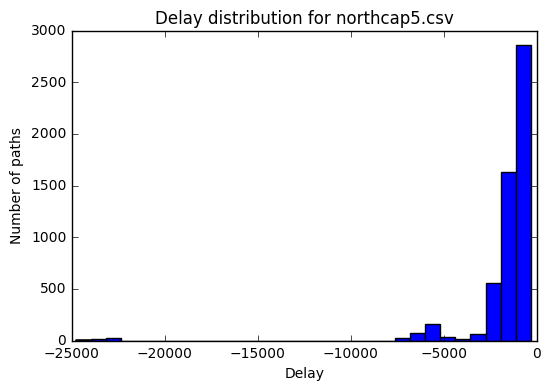

Minimum delay: -25936.967875669114
Maximum delay: 19759.9284264073


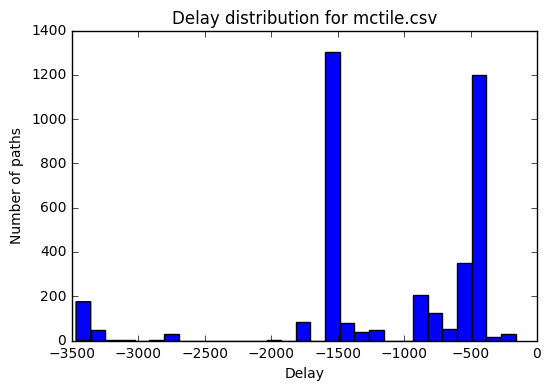

Minimum delay: -18587.847744384002
Maximum delay: 14945.33127214286


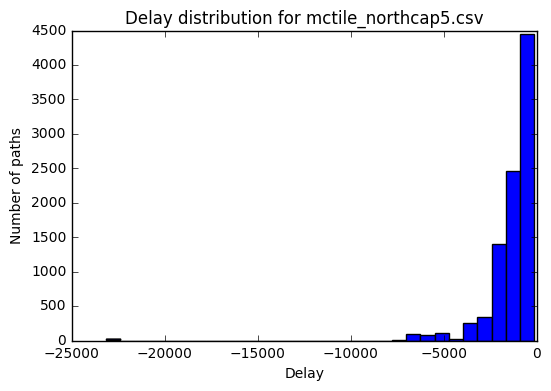

Minimum delay: -23198.746995305934
Maximum delay: 18054.269660236612


In [3]:
# What is the distribution of delay values for each of the files?
# Run model without outliers and check if the accuracy score has increased or not

fileNames = ['northcap5.csv', 'mctile.csv', 'mctile_northcap5.csv']

for file in fileNames:
    removeAllOutliers(file)


<h1>Generate Model</h1>

In [4]:
def runModels(X, Y, modelList, modelNames, showGraph, file):
    """
    INPUT: X, Y datasets, initialized list of classifiers and list of the names of models
    OUTPUT: A bar plot with the accuracy score for each model passed in. The best performing model and its score
            will be listed at the top of the graph.
    """

    
    accuracyDict = {} # Create a dictionary that maps {modelName: acc_score}
    maxAcc = 0 # Remembers the max accuracy score
    bestModel = ''
    
    Y = Y.values.ravel()
    trainX = X[:int(.8*len(X))] # Segment out the top 80% of the data
    trainY = Y[:int(.8*len(Y))]
    testX = X[int(.8*len(X)): ] # Remainder of the dataset
    testY = Y[int(.8*len(Y)): ]
    #plt.hist(testY)
    #plt.show()

    
    # Loop through the models
    for i in range(len(modelList)):
        model = modelList[i]
        modelName = modelNames[i]
        model.fit(trainX, trainY) # Train the model on the training data

        # Plot distribution of predictions vs distribution of actual values
        trainPredictions = model.predict(trainX) # Predict on the training data
        testPredictions = model.predict(testX) # Predict on the testing data
    
        # Histogram of predictions vs the actual labels 
        # Shows whether there are any patterns in the model's predictions as compared to the data
        #print('predictions: ' + str(predictions[:10]))
        #print('actual: ' + str(testY[:10]))
        #plt.hist(testPredictions, alpha=0.5, label='Test Predictions')
        #plt.hist(testY, alpha=0.5, label='Actual')
        #plt.legend(loc='upper right')
        #plt.show()

        # Compute accuracy of predictions
        trainAcc = sum([pred == act for pred, act in zip(trainPredictions, trainY)]) / len(trainPredictions)
        testAcc = sum([pred == act for pred, act in zip(testPredictions, testY)]) / len(testPredictions)
        
        accuracyDict[modelName] = testAcc 
        if testAcc > maxAcc:
            maxAcc = max(maxAcc, testAcc) # update the maxAcc if necessary
            bestModel = modelName
            
#         # Running progress of this loop
#         print('Model: ' + str(modelName))
#         print('training accuracy: ' + str(trainAcc))
#         print('testing accuracy: ' + str(testAcc))

    # Plot a histogram of the accuracies of each model
    if showGraph:
        plt.title('%s Testing Accuracy' %(file), fontsize=16)
        plt.bar(range(len(accuracyDict)), accuracyDict.values(), align='center')
        plt.xticks(range(len(accuracyDict)), accuracyDict.keys(), rotation=55)
        plt.ylabel('Testing accuracy', fontsize=14)
        plt.show()
        print("Best model is %s with accuracy %f\n\n" %(bestModel, maxAcc))
        
    return(maxAcc)
    

<h1>Run Model</h1>

In [5]:
# All necessary libraries for models
# Import necessary libraries

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

modelNames = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Polynomial SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost", "QDA"]

# Initialize the classifiers
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    SVC(kernel='poly', C=0.025),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    QuadraticDiscriminantAnalysis()
]

File: northcap5.csv


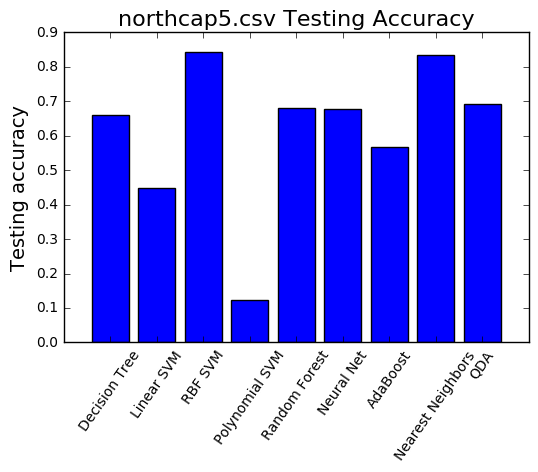

Best model is RBF SVM with accuracy 0.844284


File: mctile.csv


/Users/aiswaryasankar/anaconda3/lib/python3.4/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


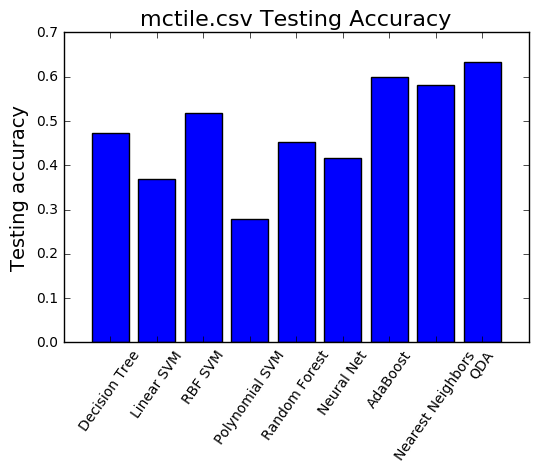

Best model is QDA with accuracy 0.633028


File: mctile_northcap5.csv


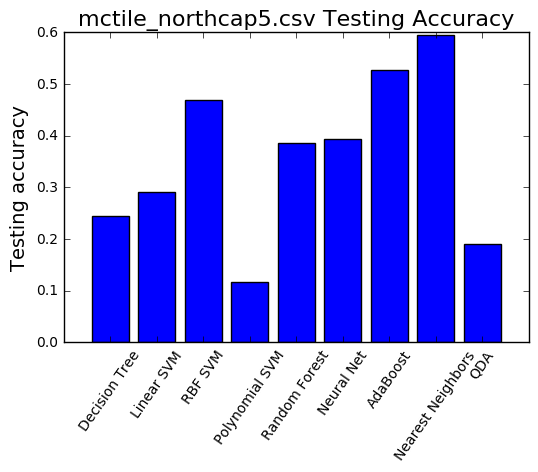

Best model is Nearest Neighbors with accuracy 0.595518




In [6]:
"""
Execute a model by calling processData(dataset), runModels(X,Y,classifiers, modelNames)
"""

for file in fileNames:
    X, Y = processData(file, True, False) # Remove outliers but remove the clock labels
    print('File: %s' %(file))
    runModels(X, Y, classifiers, modelNames, True, file)
    

<h1>Hyperparameter Tuning</h1>

In [9]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


def hyperParameterSVM(X, Y):
    """
    INPUT: X and Y datasets and the kernel type for the SVM
    OUTPUT: The best gamma and C values for the given SVM kernel
    """
    kernels = ["rbf"]
    
    for kernelStr in kernels:
        C_range = [10**i for i in range(0,4)] # High C = high bias, low C = high variance
        gamma_range = [10**i for i in range(0,4)] # High gamma = high variance

        param_grid = dict(gamma=gamma_range, C=C_range)
        cv = KFold(n_splits=3, shuffle=True)

        grid = GridSearchCV(SVC(kernel=kernelStr), param_grid=param_grid, cv=cv) 

        grid.fit(X, Y)

        print("The best parameters for kernel %s are %s with a score of %0.2f" % 
          (kernelStr, grid.best_params_, grid.best_score_))

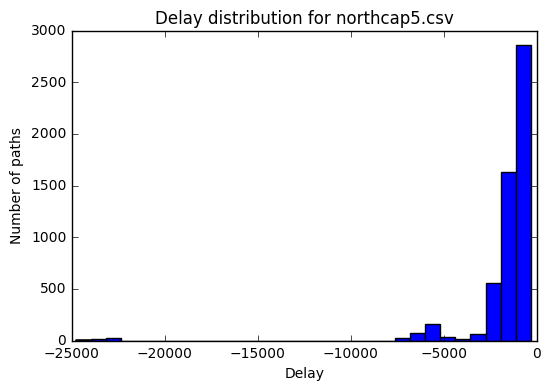

Minimum delay: -25936.967875669114
Maximum delay: 19759.9284264073
The best parameters for kernel rbf are {'C': 1000, 'gamma': 10} with a score of 0.84


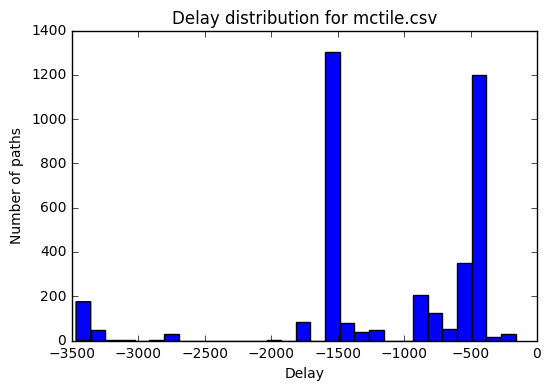

Minimum delay: -18587.847744384002
Maximum delay: 14945.33127214286
The best parameters for kernel rbf are {'C': 1000, 'gamma': 100} with a score of 0.81


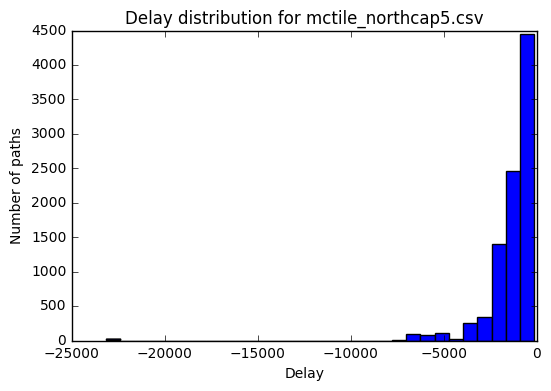

Minimum delay: -23198.746995305934
Maximum delay: 18054.269660236612
The best parameters for kernel rbf are {'C': 1000, 'gamma': 100} with a score of 0.85


In [10]:
for file in fileNames:
    X, Y = processData(file, False, True)
    hyperParameterSVM(X, Y.values.ravel())

<h1>Individual Feature Models</h1>

In [23]:
import operator

def checkFeatures(X, Y, file):
    """
    INPUT: X, Y datasets. Chooses the best model from previous analysis given the file. Then runs that model on
           each feature in the dataset. 
    OUTPUT: A histogram showing the accuracy attained from training the model using the given feature. The best feature
            is returned along with its score. Run for each of the files passed in.
    
    """
    
    columns = ['noInverters','noBuffers','noCells','noBlocks', 'maxFanout', 'sumFanout']
    classifiers = [KNeighborsClassifier(3), SVC(gamma=2, C=1)] # These models performed the best overall
    modelNames = ['Nearest Neighbors', 'RBF SVM']
    
    colMap = {}
    
    for i in range(len(X.iloc[0])): # loop through the columns not including the column for labels
        Xcol = X.iloc[:,i:i+1]
        #print('Accuracy for feature: ' + str(columns[i]))
        colMap[columns[i]] = runModels(Xcol, Y, classifiers, modelNames, False, file) # Run models with one data column
    
    #print(colMap) # print the accuracy of each column in a histogram
    plt.bar(range(len(colMap)), colMap.values(), align='center')
    plt.xticks(range(len(colMap)), colMap.keys(), rotation=25)
    plt.xlabel('Features', fontsize=14)
    plt.ylabel('Testing accuracy', fontsize=14)
    plt.title('Feature Accuracies for %s' %(file), fontsize=16)
    plt.show()
    
    maximum = max(colMap, key=colMap.get)  # Just use 'min' instead of 'max' for minimum.
    
    print('Feature %s with top accuracy %f' %(maximum, colMap[maximum]))

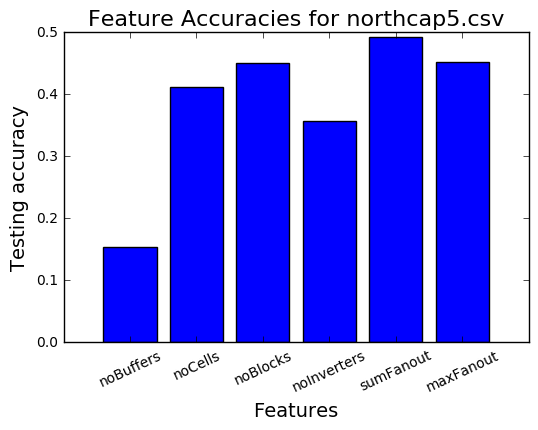

Feature sumFanout with top accuracy 0.492349


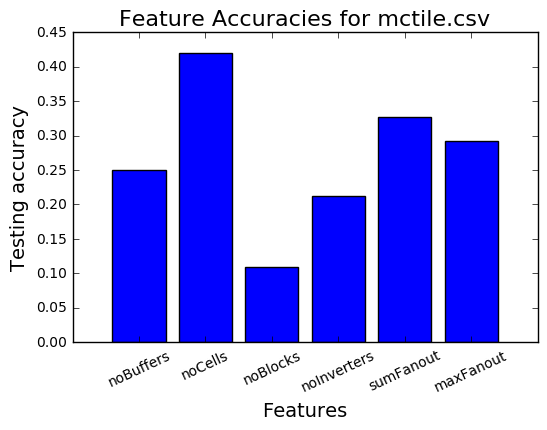

Feature noCells with top accuracy 0.419397


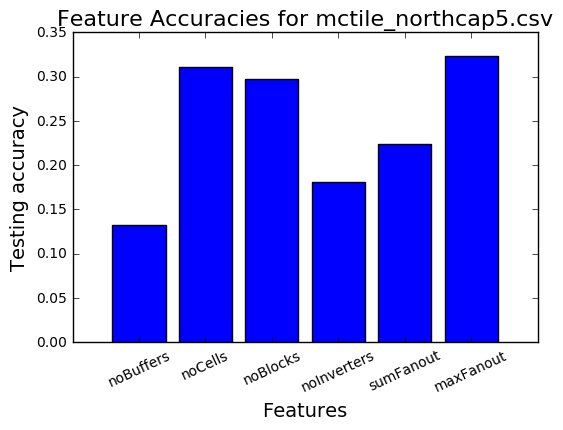

Feature maxFanout with top accuracy 0.323372


In [24]:
for file in fileNames:
    X, Y = processData(file, True, False)
    checkFeatures(X, Y, file)

<h1>Feature Correlation</h1>

In [29]:
# Plot of the correlation values between the different features and the output
# A high number means the variables have a strong correlation and thus one can be used to predict the other
# A small number means little to no correlation and they aren't good predictors of each other

def computeCorrelation(X,Y, columns):
    """
    INPUT: Computes the correlation between each feature in the dataset and the Y column. 
    OUTPUT: A table of correlation values.
    """
    for i in range(len(X.iloc[0])):
        print('Correlation ' + str(columns[i]) + str(X.iloc[:,i:i+1].corrwith(Y))) 
        # Gets a column of data from X and correlates with Y
    

In [30]:
for file in fileNames:
    columns = ['noBuffers','noInverters','noCells','noBlocks', 'maxFanout', 'sumFanout']
    #X, Y = processData(file, True, False)

<h1>Dimensionality Reduction: PCA</h1>

In [31]:
from sklearn.decomposition import PCA

def dimensionalityReductionPCA(X, Y, model, modelName, file):
    """
    INPUT: X, Y datasets, initialized list of classifiers and list of the names of models
    OUTPUT: A bar plot with the accuracy score for each model passed in. The best performing model and its score
            will be listed at the top of the graph.
    """
    
    accuracyDict = {} # Create a dictionary that maps {numFeatures: acc_score}
    maxAcc = 0 # Remembers the max accuracy score
    bestNumFeatures = 0
    Y = Y.values.ravel()
    
    for numFeatures in range(1, len(X.iloc[0])):
        pca = PCA(n_components=numFeatures)
        Xnew = pca.fit_transform(X)

        trainX = Xnew[:int(.8*len(Xnew))] # Segment out the top 80% of the data
        trainY = Y[:int(.8*len(Y))]
        testX = Xnew[int(.8*len(Xnew)): ] # Remainder of the dataset
        testY = Y[int(.8*len(Y)): ]
    
        model.fit(trainX, trainY) # Train the model on the training data

        # Plot distribution of predictions vs distribution of actual values
        trainPredictions = model.predict(trainX) # Predict on the training data
        testPredictions = model.predict(testX) # Predict on the testing data
    
        # Histogram of predictions vs the actual labels 
        # Shows whether there are any patterns in the model's predictions as compared to the data
        #print('predictions: ' + str(predictions[:10]))
        #print('actual: ' + str(testY[:10]))
        #plt.hist(testPredictions, alpha=0.5, label='Test Predictions')
        #plt.hist(testY, alpha=0.5, label='Actual')
        #plt.legend(loc='upper right')
        #plt.show()

        # Compute accuracy of predictions
        trainAcc = sum([pred == act for pred, act in zip(trainPredictions, trainY)]) / len(trainPredictions)
        testAcc = sum([pred == act for pred, act in zip(testPredictions, testY)]) / len(testPredictions)
        
        accuracyDict[numFeatures] = testAcc 
        if testAcc > maxAcc:
            maxAcc = max(maxAcc, testAcc) # update the maxAcc if necessary
            bestNumFeatures = numFeatures
            
        # Running progress of this loop
        #print('Model: ' + str(modelName))
        #print('training accuracy: ' + str(trainAcc))
        #print('testing accuracy: ' + str(testAcc))

    # Plot a histogram of the accuracies of each model
    plt.bar(range(len(accuracyDict)), accuracyDict.values(), align='center')
    plt.title('Test Accuracy after PCA for %s' %(file), fontsize=16)
    plt.xticks(range(len(accuracyDict)), accuracyDict.keys(), rotation=25)
    plt.xlabel('Number of features', fontsize=15)
    plt.ylabel('Testing accuracy', fontsize=15)
    plt.show()
    print("Best model has %f features with accuracy %f\n\n" %(bestNumFeatures, maxAcc))
    return(maxAcc)


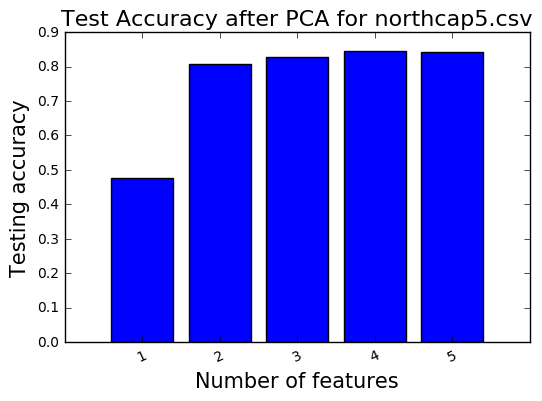

Best model has 4.000000 features with accuracy 0.845185




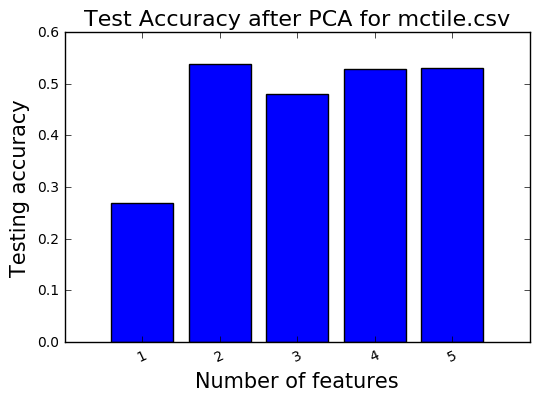

Best model has 2.000000 features with accuracy 0.538663




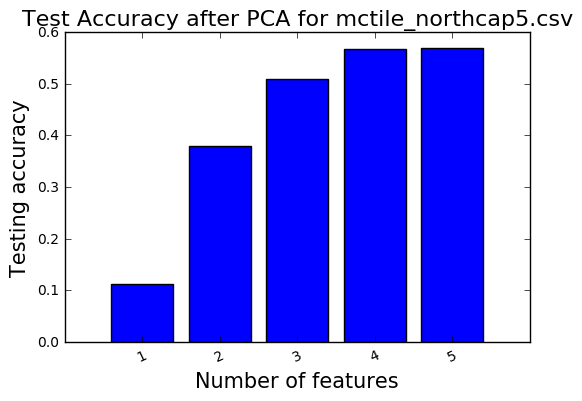

Best model has 5.000000 features with accuracy 0.568837




In [32]:
# Now perform PCA on the dataset with the best classifier I've chosen 
# thus far
model = SVC(gamma=10, C=10)
modelName = 'RBF SVC'

for file in fileNames:
    X, Y = processData(file, True, False)
    dimensionalityReductionPCA(X, Y, model, modelName, file)


<h1>Neural Net: Tensorflow</h1>

In [ ]:
# Imports
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing

# Read in the data
train = pd.read_csv('machLearn.csv', error_bad_lines=False)

# Shuffle the data
train = train.sample(frac=1).reset_index(drop=True)

# Split data into X, Y
X = train.iloc[:,2:-1] # Ignore the categorical variables to start with
Y = train.iloc[:,-1]

# Normalize the data
X_scaled = preprocessing.scale(X) # Scale the X data

# Discretize the Y values
block = 20
num_labels = 5
bins = [np.percentile(Y, percent) for percent in range(0, 100, block)]
discreteY = np.digitize(Y, bins)

# One hot encode the Y values
one_hot_Y = pd.get_dummies(discreteY)

# Split data into train, test
trainX = X_scaled[:int(.8*len(X))] # Segment out the top 80% of the data
trainY = one_hot_Y[:int(.8*len(one_hot_Y))]
testX =  X_scaled[int(.8*len(X)): ] # Remainder of the dataset
testY = one_hot_Y[int(.8*len(one_hot_Y)): ]

In [ ]:
# Minibatch
batch_size = 200
no_features = 4 # This depends on the dataset being used
steps = 10000

# Set up the graph
graph = tf.Graph()

with graph.as_default():
    
    # Set up placeholders for trainX, trainY since passed in as a minibatch
    tf_train_X = tf.placeholder(tf.float32, shape=(batch_size, no_features))
    tf_train_Y = tf.placeholder(tf.float32, shape=(batch_size, num_labels)) # one-hot encode the labels
    print(tf_train_X.get_shape())
    print(tf_train_Y.get_shape())
    
    # Set up constant for testX since using the entire testing dataset
    tf_test_X = tf.constant(testX, dtype=tf.float32)
    
    # Set up variables for the weights and biases
    weights = tf.Variable(tf.truncated_normal([no_features, num_labels])) # randomly initialize the weights
    biases = tf.Variable(tf.zeros([num_labels]))
    
    # Compute operation using matmul
    output = tf.matmul(tf_train_X, weights) + biases
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_Y, logits=output))

    # Set up optimizer
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
    # Compute predictions
    tf_train_predictions = tf.nn.softmax(output)
    tf_test_predictions = tf.nn.softmax(tf.matmul(tf_test_X, weights) + biases)
    

<h1>Extra</h1>

In [ ]:
#     print('Remove clock, Remove outliers')
#     X, Y = processData(file, False, True)
#     runModels(X, Y, classifiers, modelNames)
#     print('Keep clock, keep outliers')
#     X, Y = processData(file, True, False)
#     runModels(X, Y, classifiers, modelNames)
#     print('Remove clock, Keep outliers')
#     X, Y = processData(file, False, False)
#     runModels(X, Y, classifiers, modelNames)